# Yelp Restaurant Business Info Prediction

Team 5: Shruti Agarwal, Rashi Ghosh, Sukanya Rangarajan, Thushara Tom, Moulya Soma Sundara

# Data Scraping

Module 1: This Block of code generate a txt extension file ("restaurantList.txt") that contains the list of restaurant names,unique biz_id and url.

In [13]:
#import libraries
from bs4 import BeautifulSoup
import math
import re
import time
import requests 


#function to check whether the restaurant is Ad or not
def isAd(restaurantBlock):
    ad = True
    adChunk = restaurantBlock.find('span', {'class': 'yloca-tip'})
    if adChunk == None: ad = False
    return ad


#function to parse the restaurant name 
def getRestaurantName(restaurantBlock):
    name = 'NA' #initializing name
    nameChunk = restaurantBlock.find('a', {'class': 'biz-name js-analytics-click'})
    if nameChunk: name = nameChunk.text
    return name

# function to parse the restaurant href
def getRestaurantHref(restaurantBlock):
    href = 'NA' #initializing href
    hrefChunk = restaurantBlock.find('a', {'class': 'biz-name js-analytics-click'})
    if hrefChunk: href = hrefChunk['href'].split("?")[0] 
    return href

#function to fetch the restaurant username
def getRestaurantUsername(restaurantUrl):
    username = 'NA'
    if restaurantUrl: username = restaurantUrl.split("/")[4] 
    return username

#function to scrape restatuarant names and url from yelp
def restaurantsListScrapper(restaurantCount, domain, cuisine, location):
    restaurantsList = open('restaurantsList.txt', 'w') #output file
    for page in range(0, restaurantCount):
        if (page % 10 == 0):
            srcUrl = domain + "/search?find_desc=" + cuisine + "&find_loc=" + location + "&start=" + str(page);
            html = None
            
            for i in range(5):
                try: #use the browser to access the url
                    response = requests.get(srcUrl,headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36', })
                    html = response.content #get the html
                    break #we got the file, break the loop
                except Exception as e: #browser.open() threw an exception, the attempt to get the response failed
                    print ('failed attempt', i)
                    time.sleep(1) #wait 1 secs
            
            if not html: continue #couldn't get the page, ignore
            
            htmlParser = BeautifulSoup(html.decode('ascii', 'ignore'), 'lxml') # parse the html
            restaurantBlocks = htmlParser.findAll('div', {'class':re.compile('main-attributes')}) # get all the review 'div' tags
            
            for restaurantBlock in restaurantBlocks:
                if(isAd(restaurantBlock) == False):
                    name = getRestaurantName(restaurantBlock)
                    href = domain + getRestaurantHref(restaurantBlock)
                    username = getRestaurantUsername(href)
 
                    restaurantsList.write(name + '\t' + username + '\t' + href + '\n') # write to file
                    
    restaurantsList.close() #close file             

# main function
if __name__ == '__main__':
    restaurantCount = 10 #number of restuarants to scrape
    domain = "https://www.yelp.com" #Website domain name
    cuisine = "Food+-+Korean" #Type of cuisine the restaurant offers
    location = "Manhattan%2C+NY" #Location of the restaurant
    
    restaurantsListScrapper(restaurantCount, domain, cuisine, location)

Module 2: This block of code takes as input the restaurant list from a file generated by the above code and scrapes webpages of every restaurants in the input file. As an output, the script creates html extension pages. The html pages are the reviews pages for every restaurant. These html pages are created under the name of restaurant folder on a given path.

In [2]:
#import libraries
from bs4 import BeautifulSoup
import math
import re
import time
import requests 
import os

#function to add every url in the file to a set
def getRestaurantsUrl(filename):
    file = open(filename) #read data from file 
    urlList = [] #url list
    for line in file: #foreach line in the file
        urlList.append(line.split('\t')[2].strip())    
    file.close()
    return urlList

#function to add every username in the file to a set
def getRestaurantUsername(filename):
    file = open(filename) #read data from file 
    usernameList = [] #username list
    for line in file: #foreach line in the file
        usernameList.append(line.split('\t')[1].strip())
    file.close()
    return usernameList

#function to fetch the number of review pages
def getReviewPageCount(url):
    response=requests.get(url, headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36', })
    html = response.content #get the html              
    htmlParser = BeautifulSoup(html.decode('ascii', 'ignore'),'lxml') #parse the html into beautiful soup
    page = htmlParser.find('div', {'class':re.compile('page-of-pages arrange_unit arrange_unit--fill')}) #get maximum pages
    page = str(page.text)
    page = page.strip().split()
    page = int(page[1])
    return page

#function to scrape restatuarant names and url from yelp
def restaurantsHtmlScrapper(restaurantsListFile, path):
    urlList = getRestaurantsUrl(restaurantsListFile) #get list of restaurants urls
    usernameList = getRestaurantUsername(restaurantsListFile) #get list of restaurants usernames
    restaurantsCount = len(usernameList)
    
    index = 0
    while index < restaurantsCount: #foreach restaurant
        html = None
        url = urlList[index] #url of a restaurant
        username = usernameList[index] #username of a restaurant
        reviewPageCount = getReviewPageCount(url) #number of review pages
        
        if not os.path.exists(path + username): #create a directory for the restaurant
            os.mkdir(path + username)
        
        for page in range(0, reviewPageCount): #foreach review page
            reviewUrl = url + "?start=" + str(page * 20)
            filename = path + username + "/" + username + "-page-" + str(page) + ".html"
            
            restaurantsHtml = open(filename, 'w')
            for i in range(5):
                try: #use the browser to access the url
                    response = requests.get(reviewUrl, headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36', })
                    html = response.content #get the html
                    break #we got the file, break the loop
                except Exception as e: #browser.open() threw an exception, the attempt to get the response failed
                    print ('failed attempt', i)
                    time.sleep(2) #wait 2 secs
    
            if not html: continue #couldn't get the page, ignore
            
            htmlParser = BeautifulSoup(html.decode('ascii', 'ignore'), 'lxml') # parse the html into beautiful soup
            restaurantsHtml.write(str(htmlParser)) #htmlParser.prettify() for prettiness
            restaurantsHtml.close() #close the file
        
        index += 1

# main function
if __name__ == '__main__':
    restaurantsListFile = "/Users/moulyasomasundara/AnacondaProjects/Final Scrape/restaurantsList.txt" #file and its location
    restaurantsDataPath = "/Users/moulyasomasundara/AnacondaProjects/Final Scrape/" #base path to save the scrapped data
    restaurantsHtmlScrapper(restaurantsListFile, restaurantsDataPath)

Module 3: This code block reads all the review pages for every restaurant folder present in the root folder. Then it scrapes all the reviews for a restaurant and saves them in a text file within the restaurant folder. 

In [3]:
#import libraries
import fnmatch
import os
import re
from bs4 import BeautifulSoup

#function to get the name of the directory from the path
def getDirectoryName(path):
    directoryList = path.split("/")
    return directoryList[len(directoryList) - 1]

#function to check whether the value container is empty
def isEmpty(value):
    if len(value) == 0: return True
    return False
    
#function to get list of scrapped files
def filesList(basePath):
    pathDictionary = {} #dictionary contains the restaurant username as key and list of page path as a value
    
    for root, directories, files in os.walk(basePath):
        directory = getDirectoryName(root) #fetching name of the current directory
        pathDictionary[directory] = [] #defining empty list to every key
        
        for filename in fnmatch.filter(files, '*.html'): #foreach file in the directory
            pathDictionary[directory].append(os.path.join(root, filename)) #adding matched file path in the dictionary
        
    return pathDictionary #returning directory
            
#function to scrape reviews from each file for each restaurant directory
def reviewScrapper(restaurantDictionary, basePath):
    path = basePath  + "/" #path of expected output 

    globalFile = open(path + "reviews.txt", 'w') #create a main review file: contains reviews of every restaurant    

    for key,value in restaurantDictionary.items(): #foreach each key in the restaurant dictionary
        if not isEmpty(value):
            outFile = open(path + key + "/" + key + "-reviews.txt", 'w') #create restaurant specific review file
            
            for index in range (0, len(value)): #foreach value/path in the value list
                inFile = open(value[index], 'r').read() #read all data from file
                
                htmlParser = BeautifulSoup(inFile.encode('ascii', 'ignore'), 'lxml') #parse string into beautiful soup
                reviews = htmlParser.findAll('div', {'class': re.compile('review-content')}) #extract reviews containers               
                
                for reviewText in reviews:
                    reviewText = reviewText.find('p', {'lang': 'en'}).text #fetch review text from every container 
                    outFile.write(reviewText + "\n") #write restaurant specific review in file
                    globalFile.write(reviewText + "\n") #write reviews for every restaurant 
                    
            outFile.close() #close restaurant specific review file
    globalFile.close() #close main review file

# main function
if __name__ == '__main__':
    basePath = "/Users/moulyasomasundara/AnacondaProjects/Final Scrape/"
    restaurantDictionary = filesList(basePath)
    reviewScrapper(restaurantDictionary,basePath)

Module 4: This code block reads all the review pages for every restaurant folder present in the root folder. Then it scrapes all the business info for a restaurant and saves them in a text file under the restaurant folder.

In [6]:
#import libraries
import fnmatch
import os
import re
from bs4 import BeautifulSoup

#function to get the name of the directory from the path
def getDirectoryName(path):
    directoryList = path.split("/")
    return directoryList[len(directoryList) - 1]

#function to check whether the value container is empty
def isEmpty(value):
    if len(value) == 0: return True
    return False
    
#function to get list of scrapped files
def getFilesList(basePath):
    pathDictionary = {} #dictionary contains the restaurant username as key and list of page path as a value
    #filename = restaurentName + '-page-0.html'
    for root, directories, files in os.walk(basePath):
        directory = getDirectoryName(root) #fetching name of the current directory
        pathDictionary[directory] = '' #defining empty list to every key
        
        for filename in fnmatch.filter(files, '*.html'): #foreach file in the directory
            pathDictionary[directory] = os.path.join(root, filename) #adding matched file path in the dictionary
    #print(pathDictionary) 
    
    return pathDictionary #returning directory
            
#function to scrap reviews from each file for each restaurant directory
def reviewScrapper(restaurantDictionary, basePath):
    path = basePath  #path of expected output 

    globalFile = open(path + "bi.txt", 'w') #create a main review file: contains reviews of every restaurant    
    infoDict = {} #create a dictionary
    for key,value in restaurantDictionary.items(): #foreach each key in the restaurant dictionary
        if not isEmpty(value):
            outFile = open(path + key + "/" + key + "-bi.txt", 'w') #create restaurant specific review file
            inFile = open(value, 'r').read() #read all data from file
            htmlParser = BeautifulSoup(inFile.encode('ascii', 'ignore'), 'lxml') #parse string into beautiful soup
            reviews = htmlParser.findAll('dl') #extract reviews containers               
            for reviewText in reviews:
                biText = reviewText.find('dt').text.strip() #fetch review text from every container
                if biText == 'Parking' or biText == 'Good for Kids' or biText == 'Good for Groups' or biText == 'Wi-Fi' or biText == 'Outdoor Seating':      
                    infoDict[biText] = reviewText.find('dd').text.strip()
                    outFile.write(biText + "\t"+ infoDict[biText] + "\n") #write restaurant specific review in file
                    globalFile.write(biText + "\t"+ infoDict[biText] + "\n") #write reviews for every restaurant     
            outFile.close() #close restaurant specific review file
    globalFile.close() #close main review file
    

# main function
if __name__ == '__main__':
    basePath = "/Users/moulyasomasundara/AnacondaProjects/Final Scrape/" #directory path of saved scrapped data
    restaurantDictionary = getFilesList(basePath)
    reviewScrapper(restaurantDictionary, basePath)

# Data Preparation

Module 5: In this block of code we read the CSV file which has the list of restaurant names.

In [14]:
import os
import pandas as pd
#Loading the restaurant names
os.chdir('/Users/moulyasomasundara/AnacondaProjects/Final Scrape/')
rest_names = pd.read_csv('restaurantList.csv')
print(rest_names.head(10))

                               Restaurants
0  woorijip-authentic-korean-food-new-york
1                    jongro-bbq-new-york-3
2                      barn-joo-new-york-3
3               bann-restaurant-new-york-4
4          kang-ho-dong-baekjeong-new-york
5                    grace-street-new-york
6                            kook-new-york
7                          hanjan-new-york
8                     korilla-bbq-new-york
9                            cote-new-york


In [15]:
#Creating required business info
rev_data = pd.DataFrame(columns = ['Restaurant_Names','Restaurant_Reviews'])

Module 6: Here, we are reading the reviews from the text file created in Module 3 and creating a Data Frame 'rev_data'with the restaurant names.

In [16]:
k = 0
for p in range(len(rest_names)):
    os.chdir('/Users/moulyasomasundara/AnacondaProjects/Final Scrape/' + rest_names.Restaurants[p])
    f = open(rest_names.Restaurants[p]+ '-reviews.txt', 'r')
    x = f.readlines()
    rev = str()
    for q in range(len(x)):
        x[q] = x[q].lower().strip()
        x[q] = re.sub('[^A-Za-z0-9\n.\s]', '', x[q])
        rev += ' ' + x[q]
    rev_data.loc[k] = [rest_names.Restaurants[p],rev]
    k = k+1

In [17]:
rev_data

,Restaurant_Names,Restaurant_Reviews
0,woorijip-authentic-korean-food-new-york,ive been working in midtown for the past 5 ye...
1,jongro-bbq-new-york-3,i came here for the first time during a visit...
2,barn-joo-new-york-3,the best fancy happy hour in the neighborhood...
3,bann-restaurant-new-york-4,the food was excellent. the blackened was the...
4,kang-ho-dong-baekjeong-new-york,im no stranger to khd my friends and i frequ...
5,grace-street-new-york,i dont usually write reviews but grace street...
6,kook-new-york,went here on a weekend afternoon there was no...
7,hanjan-new-york,we visited this restaurant in the summer when...
8,korilla-bbq-new-york,the famous korean chipotle as many east villa...
9,cote-new-york,this recent michelen star restaurant was impr...


# Converting topics into a Dataframe

Module 7: Here, we are reading the business info from the text files extracted in Module 4 and creating a Data Frame 'df'with the restaurant names, reviews and all the five business info parameters.

In [18]:
df = pd.DataFrame(columns=['Rest_Names','Parking','Good for Kids','Good for Groups','Outdoor Seating','Wifi'])
k = 0
for p in range(len(rest_names)):
    os.chdir('/Users/moulyasomasundara/AnacondaProjects/Final Scrape/'+ rest_names.Restaurants[p])
    f = open(rest_names.Restaurants[p] + '-bi.txt', 'r')
    message = f.read()
    message = re.sub('[^A-Za-z0-9\s\t]', '', message)
    #print(x)
    message = message.splitlines()
    for i in range(len(message)):
        if i == 0:
            x = message[i].split()
            #print(x)
            parking = x[-1]
        if i == 1:
            x = message[i].split()
            #print(x)
            kids = x[-1]  
        if i == 2:
            x = message[i].split()
            #print(x)
            groups = x[-1] 
        if i == 3:
            x = message[i].split()
            #print(x)
            outdoor = x[-1] 
        if i == 4:
            x = message[i].split()
            #print(x)
            wifi = x[-1] 
    df.loc[p] = [rest_names.Restaurants[p],parking,kids,groups,outdoor,wifi]

 Converting all the categorical variables into binary variables

In [20]:
df

,Rest_Names,Parking,Good for Kids,Good for Groups,Outdoor Seating,Wifi
0,woorijip-authentic-korean-food-new-york,Street,Yes,Yes,No,No
1,jongro-bbq-new-york-3,Street,Yes,Yes,No,No
2,barn-joo-new-york-3,Street,No,Yes,Yes,No
3,bann-restaurant-new-york-4,Street,Yes,Yes,No,No
4,kang-ho-dong-baekjeong-new-york,Street,Yes,Yes,No,Free
5,grace-street-new-york,Street,No,No,No,Free
6,kook-new-york,Street,Yes,Yes,No,Free
7,hanjan-new-york,Street,No,Yes,No,No
8,korilla-bbq-new-york,Street,No,Yes,No,No
9,cote-new-york,Street,No,Yes,No,No


Module 8: Converting categorical variables into binary values

In [21]:
for i in range(len(df)):
    if ((df['Parking'][i] == 'Street')):
        df.Parking[i] = 0
    elif ((df['Parking'][i] == 'Lot')):
        df.Parking[i] = 1
    elif (df['Parking'][i] == 'Garage'):
        df.Parking[i] = 1
    elif (df['Parking'][i] == 'Yes'):
        df.Parking[i] = 1
    elif (df['Parking'][i] == 'No'):
        df.Parking[i] = 0
#Good for Kids Column
    if ((df['Good for Kids'][i] == 'Yes')):
        df['Good for Kids'][i] = 1
    elif ((df['Good for Kids'][i] == 'No')):
        df['Good for Kids'][i] = 0
#Good for Groups Column
    if ((df['Good for Groups'][i] == 'Yes')):
        df['Good for Groups'][i] = 1
    elif ( (df['Good for Groups'][i] == 'No')):
        df['Good for Groups'][i] = 0
#Outdoor Seating Column
    if ((df['Outdoor Seating'][i] == 'Yes')):
        df['Outdoor Seating'][i] = 1
    elif ((df['Outdoor Seating'][i] == 'No')):
        df['Outdoor Seating'][i] = 0
    elif ((df['Outdoor Seating'][i] == 'Free')):
        df['Outdoor Seating'][i] = 1
#Wifi Column
    if ((df['Wifi'][i] == 'Yes')|(df['Wifi'][i] == 'Free')):
        df['Wifi'][i] = 1
    elif ((df['Wifi'][i] == 'No')):
        df['Wifi'][i] = 0
    elif ((df['Wifi'][i] == 'Paid')):
        df['Wifi'][i] = 1

In [22]:
dfFinalDataset = df.merge(rev_data, left_on='Rest_Names', right_on='Restaurant_Names', how='inner')

,Rest_Names,Parking,Good for Kids,Good for Groups,Outdoor Seating,Wifi
0,gogi-grill-hoboken-3,0,1,1,1,1
1,barn-joo-35-new-york,0,0,1,0,0
2,purple-rice-korean-kitchen-new-york,0,1,1,0,0
3,space-mabi-new-york,1,1,0,1,1
4,jeju-noodle-bar-new-york,0,0,1,0,1
5,halmae-noodle-palisades-park,0,1,1,0,1


In [22]:
FinalDataset = df.merge(rev_data, left_on='Rest_Names', right_on='Restaurant_Names', how='inner')

This is only a sample of our data set. Our final data set "yelp_data.xlsx" contains the entire data.

In [24]:
FinalDataset.drop(['Restaurant_Names'], axis = 1)

,Rest_Names,Parking,Good for Kids,Good for Groups,Outdoor Seating,Wifi,Restaurant_Reviews
0,gogi-grill-hoboken-3,0,1,1,1,1,i got a delivery of korean spicy chicken bowl...
1,barn-joo-35-new-york,0,0,1,0,0,good restaurant the decor is very nice good s...
2,purple-rice-korean-kitchen-new-york,0,1,1,0,0,as a korean this place is like meh. kimchi fr...
3,space-mabi-new-york,1,1,0,1,1,review for space mabi cafe 830am430pmfantasti...
4,jeju-noodle-bar-new-york,0,0,1,0,1,ambience if you have craving for noodle but s...
5,halmae-noodle-palisades-park,0,1,1,0,1,cant believe i wasnt aware of this place till...


# The following blocks of code appends reviews of each restaurant with their corresponding Business Info Parameters

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

def run():
    df = pd.read_excel('yelp_data.xlsx', sheetname=None)
    data=df["Sheet1"]
    file = open('scrapeParking.txt','w')
    stopLex=set(stopwords.words('english'))
    c=data.shape[0]
    num_of_rows=int(c)-1
    for i in range(num_of_rows):
        restName= data.Rest_Names[i]
        park=data.Parking[i]
        reviewLine=data.Restaurant_Reviews[i]
        sentences=sent_tokenize(reviewLine)
        for sentence in sentences:
            file.write(str(sentence)+"\t"+str(park)+"\n")

if __name__=='__main__':
  check= run()

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

def run():
    df = pd.read_excel('yelp_data.xlsx', sheetname=None)
    data=df["Sheet1"]
    file = open('scrapeKids.txt','w')
    stopLex=set(stopwords.words('english'))
    c=data.shape[0]
    num_of_rows=int(c)-1
    for i in range(num_of_rows):
        gok=data['Good for Kids'][i]
        reviewLine=data.Restaurant_Reviews[i]
        sentences=sent_tokenize(reviewLine)
        for sentence in sentences:
            file.write(str(sentence)+"\t"+str(gok)+"\n")
if __name__=='__main__':
  check= run()

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

def run():
    df = pd.read_excel('yelp_data.xlsx', sheetname=None)
    data=df["Sheet1"]
    file = open('scrapeGroups.txt','w')
    stopLex=set(stopwords.words('english'))
    c=data.shape[0]
    num_of_rows=int(c)-1
    for i in range(num_of_rows):
        restName= data.Rest_Names[i]
        gp=data['Good for Groups'][i]
        reviewLine=data.Restaurant_Reviews[i]
        sentences=sent_tokenize(reviewLine)
        for sentence in sentences:
            file.write(str(sentence)+"\t"+str(gp)+"\n")
            
if __name__=='__main__':
  check= run()

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

def run():
    df = pd.read_excel('yelp_data.xlsx', sheetname=None)
    data=df["Sheet1"]
    file = open('scrapeOutdoor.txt','w')
    stopLex=set(stopwords.words('english'))
    c=data.shape[0]
    num_of_rows=int(c)-1
    for i in range(num_of_rows):
        os=data['Outdoor Seating'][i]
        reviewLine=data.Restaurant_Reviews[i]
        sentences=sent_tokenize(reviewLine)
        for sentence in sentences:
            file.write(str(sentence)+"\t"+str(os)+"\n")
            
if __name__=='__main__':
  check= run()

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

def run():
    df = pd.read_excel('data.xlsx', sheetname=None)
    data=df["Sheet1"]
    file = open('scrapeWifi.txt','w')
    stopLex=set(stopwords.words('english'))
    c=data.shape[0]
    num_of_rows=int(c)-1
    for i in range(num_of_rows):
        wifi=data['Wifi'][i]
        reviewLine=data.Restaurant_Reviews[i]
        sentences=sent_tokenize(reviewLine)
        for sentence in sentences:
            file.write(str(sentence)+"\t"+str(wifi)+"\n")
            
if __name__=='__main__':
  check= run()

# Classifier Algorithms


After testing with several classifiers, we got best results using MultiNomial Naive Bayes with alpha = 2.5.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

#read the reviews and their polarities from a given file
def loadData(fname):
    reviews=[]
    labels=[]
    print("loadhere")
    f=open(fname)
    for line in f:
        review,rating=line.strip().split('\t') 
        reviews.append(review.lower())    
        labels.append(int(rating))
    f.close()
    return reviews,labels

rev_train,labels_train=loadData('scrapeParking.txt')
X_train, X_test, y_train, y_test = train_test_split(rev_train, labels_train, test_size=0.30, random_state=42)
print("cntr here")

#Build a counter based on the training dataset
counter = CountVectorizer()
counter.fit(rev_train)


#count the number of times each term appears in a document and transform each doc into a count vector
counts_train = counter.transform(X_train)
counts_test = counter.transform(X_test)

# Trying with MNB and DT Algorithms 
MNB_classifier = MultinomialNB()
DT_classifier = DecisionTreeClassifier()

#label that u pick - followed by the classifier;
predictors=[('mnb',MNB_classifier),('dt',DT_classifier)]

#voting classifier;
VT=VotingClassifier(predictors) 


#which parameter u will tune n how many parameters u want to tune
#=======================================================================================

#MNB
multinomial_grid = [{'alpha': [0, 0.5, 1.0, 1.5, 2.0, 2.5]}]

# build a grid search to find the best parameters
gridsearchMNB = GridSearchCV(MNB_classifier, multinomial_grid, cv=5)
# run the grid search
gridsearchMNB.fit(counts_train, y_train)
#print the score for each parameter setting
for params, mean_score, scores in gridsearchMNB.grid_scores_:
    print (params, mean_score)
#========================================================================================   
#build the parameter grid
DT_grid = [{'max_depth': [3,4,5,6,7,8,9,10,11,12],'criterion':['gini','entropy']}]

#build a grid search to find the best parameters
gridsearchDT  = GridSearchCV(DT_classifier, DT_grid, cv=5)

#run the grid search
gridsearchDT.fit(counts_train,y_train)
#print the score for each parameter setting
for params, mean_score, scores in gridsearchDT.grid_scores_:
    print (params, mean_score)

#=======================================================================================
#this line ptimizes all three models in line 44 we tell the voting classifier what to use 
VT.fit(counts_train,y_train)

#use the VT classifier to predict
predicted=VT.predict(counts_test)

#print the accuracy
print (accuracy_score(predicted,y_test))

#============================================================================================
Output
{'alpha': 0} 0.8298890736995775
{'alpha': 0.5} 0.8248034558269215
{'alpha': 1.0} 0.8340532972753054
{'alpha': 1.5} 0.8373080927138054
{'alpha': 2.0} 0.8388158288360517
{'alpha': 2.5} 0.8393184075434671
{'criterion': 'gini', 'max_depth': 3} 0.8420227596357501
{'criterion': 'gini', 'max_depth': 4} 0.8419509626775479
{'criterion': 'gini', 'max_depth': 5} 0.84234584594766
{'criterion': 'gini', 'max_depth': 6} 0.8422740489894578
{'criterion': 'gini', 'max_depth': 7} 0.8421424212327537
{'criterion': 'gini', 'max_depth': 8} 0.8424655075446636
{'criterion': 'gini', 'max_depth': 9} 0.8421543873924542
{'criterion': 'gini', 'max_depth': 10} 0.8422501166700571
{'criterion': 'gini', 'max_depth': 11} 0.842214218190956
{'criterion': 'gini', 'max_depth': 12} 0.8421543873924542
{'criterion': 'entropy', 'max_depth': 3} 0.840814177506013
{'criterion': 'entropy', 'max_depth': 4} 0.8421184889133531
{'criterion': 'entropy', 'max_depth': 5} 0.8424056767461618
{'criterion': 'entropy', 'max_depth': 6} 0.842214218190956
{'criterion': 'entropy', 'max_depth': 7} 0.8422620828297575
{'criterion': 'entropy', 'max_depth': 8} 0.8420825904342519
{'criterion': 'entropy', 'max_depth': 9} 0.8422261843506563
{'criterion': 'entropy', 'max_depth': 10} 0.8421304550730534
{'criterion': 'entropy', 'max_depth': 11} 0.8422022520312556
{'criterion': 'entropy', 'max_depth': 12} 0.8420945565939523
0.844482912665

# Applying MultiNomial Naive Bayes on Parking Business Info attribute

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#read the reviews and their polarities from a given file
def loadData(fname):
    reviews=[]
    labels=[]
    f=open(fname)
    for line in f:
        review,rating=line.strip().split('\t') 
        reviews.append(review.lower())    
        labels.append(int(rating))
    f.close()
    return reviews,labels

rev_train,labels_train=loadData('scrapeParking.txt')
X_train, X_test, y_train, y_test = train_test_split(rev_train, labels_train, test_size=0.30, random_state=50)
counter = CountVectorizer()
counter.fit(rev_train)
counts_train = counter.transform(X_train)
counts_test = counter.transform(X_test)
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,y_train)
pred=clf.predict(counts_test)
print("Accuracy =")
print (accuracy_score(pred,y_test))

Accuracy =
0.840825329462


# Prediction for Parking

In [46]:
def loadDatax(fname):
    reviews=[]
    f=open(fname)
    for line in f:
        review=line.strip() 
        reviews.append(str(review).lower())    
    f.close()
    return reviews
X_test=loadDatax('Ganso Ramen-reviews.txt')
#Y_test=[0,0]
#print(X_test)
#count the number of times each term appears in a document and transform each doc into a count vector
counts_train = counter.transform(rev_train)#transform the training data
#print(counts_train)
counts_test = counter.transform(X_test)#transform the testing data
#print(counts_test)
#train classifier
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,labels_train)
pred=clf.predict(counts_test)
print(pred)

[0 0 0 0 0]


# Confusion Matrix for Parking 

Confusion matrix, without normalization
[[29934   238]
 [ 5463   181]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.97  0.03]]


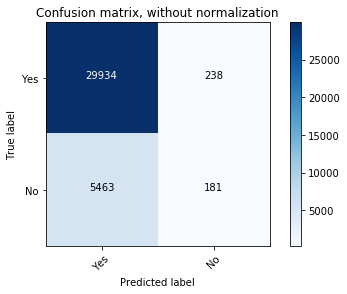

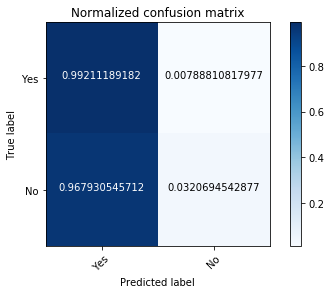

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names=['Yes','No']   
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Applying MultiNomial Naive Bayes for 'Good for Kids' Business info attribute

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#read the reviews and their polarities from a given file
def loadData(fname):
    reviews=[]
    labels=[]
    f=open(fname)
    for line in f:
        review,rating=line.strip().split('\t') 
        reviews.append(review.lower())    
        labels.append(int(rating))
    f.close()
    return reviews,labels

rev_train,labels_train=loadData('scrapeKids.txt')
X_train, X_test, y_train, y_test = train_test_split(rev_train, labels_train, test_size=0.30, random_state=50)
counter = CountVectorizer()
counter.fit(rev_train)
counts_train = counter.transform(X_train)
counts_test = counter.transform(X_test)
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,y_train)
pred=clf.predict(counts_test)
print("Accuracy =")
print (accuracy_score(pred,y_test))

Accuracy =
0.819689524235


# Prediction for Good for Kids

In [48]:
def loadDatax(fname):
    reviews=[]
    f=open(fname)
    for line in f:
        review=line.strip() 
        reviews.append(str(review).lower())    
    f.close()
    return reviews
X_test=loadDatax('Ganso Ramen-reviews.txt')
#Y_test=[0,0]
#print(X_test)
#count the number of times each term appears in a document and transform each doc into a count vector
counts_train = counter.transform(rev_train)#transform the training data
#print(counts_train)
counts_test = counter.transform(X_test)#transform the testing data
#print(counts_test)
#train classifier
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,labels_train)
pred=clf.predict(counts_test)
print(pred)

[1 1 1 1 1]


# Confusion matrix for 'Good for Kids'

Confusion matrix, without normalization
[[  724  6019]
 [  439 28634]]
Normalized confusion matrix
[[ 0.11  0.89]
 [ 0.02  0.98]]


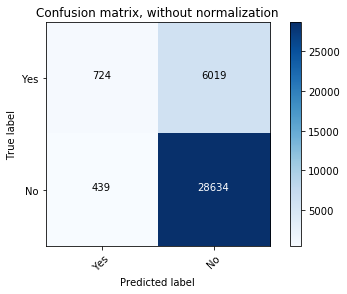

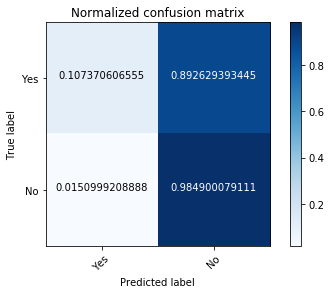

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names=['Yes','No']   
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Applying MultiNomial Naive Bayes for 'Good for Groups' Business info attribute

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#read the reviews and their polarities from a given file
def loadData(fname):
    reviews=[]
    labels=[]
    f=open(fname)
    for line in f:
        review,rating=line.strip().split('\t') 
        reviews.append(review.lower())    
        labels.append(int(rating))
    f.close()
    return reviews,labels

rev_train,labels_train=loadData('scrapeGroups.txt')
X_train, X_test, y_train, y_test = train_test_split(rev_train, labels_train, test_size=0.30, random_state=50)
counter = CountVectorizer()
counter.fit(rev_train)
counts_train = counter.transform(X_train)
counts_test = counter.transform(X_test)
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,y_train)
pred=clf.predict(counts_test)
print("Accuracy =")
print (accuracy_score(pred,y_test))

Accuracy =
0.813714540987


# Good for Groups

In [50]:
def loadDatax(fname):
    reviews=[]
    f=open(fname)
    for line in f:
        review=line.strip() 
        reviews.append(str(review).lower())    
    f.close()
    return reviews
X_test=loadDatax('Ganso Ramen-reviews.txt')
#Y_test=[0,0]
#print(X_test)
#count the number of times each term appears in a document and transform each doc into a count vector
counts_train = counter.transform(rev_train)#transform the training data
#print(counts_train)
counts_test = counter.transform(X_test)#transform the testing data
#print(counts_test)
#train classifier
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,labels_train)
pred=clf.predict(counts_test)
print(pred)

[1 1 1 1 1]


# Confusion Matrix for 'Good for Groups'

Confusion matrix, without normalization
[[  400  6343]
 [  329 28744]]
Normalized confusion matrix
[[ 0.06  0.94]
 [ 0.01  0.99]]


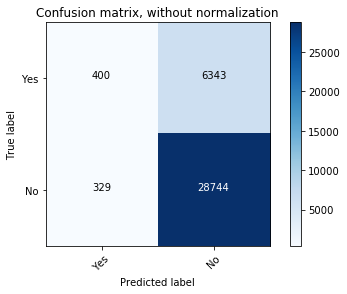

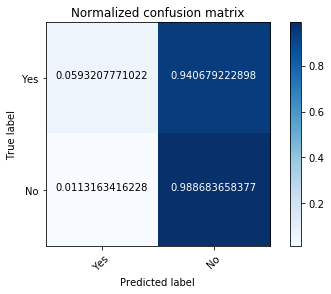

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names=['Yes','No']   
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Applying MultiNomial Naive Bayes for 'Outdoor Seating' Business info attribute

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#read the reviews and their polarities from a given file
def loadData(fname):
    reviews=[]
    labels=[]
    f=open(fname)
    for line in f:
        review,rating=line.strip().split('\t') 
        reviews.append(review.lower())    
        labels.append(int(rating))
    f.close()
    return reviews,labels

rev_train,labels_train=loadData('scrapeOutdoor.txt')
X_train, X_test, y_train, y_test = train_test_split(rev_train, labels_train, test_size=0.30, random_state=50)
counter = CountVectorizer()
counter.fit(rev_train)
counts_train = counter.transform(X_train)
counts_test = counter.transform(X_test)
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,y_train)
pred=clf.predict(counts_test)
print("Accuracy =")
print (accuracy_score(pred,y_test))

Accuracy =
0.84250055841


# Prediction for Outdoor Seating

In [52]:
def loadDatax(fname):
    reviews=[]
    f=open(fname)
    for line in f:
        review=line.strip() 
        reviews.append(str(review).lower())    
    f.close()
    return reviews
X_test=loadDatax('Ganso Ramen-reviews.txt')
#Y_test=[0,0]
#print(X_test)
#count the number of times each term appears in a document and transform each doc into a count vector
counts_train = counter.transform(rev_train)#transform the training data
#print(counts_train)
counts_test = counter.transform(X_test)#transform the testing data
#print(counts_test)
#train classifier
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,labels_train)
pred=clf.predict(counts_test)
print(pred)

[0 0 0 0 0]


# Confusion Matrix for 'Outdoor Seating'

Confusion matrix, without normalization
[[29969   197]
 [ 5444   206]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.96  0.04]]


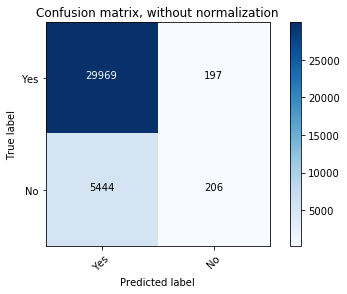

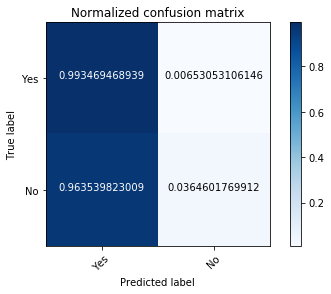

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names=['Yes','No']   
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Applying MultiNomial Naive Bayes for 'Wi-Fi' Business info attribute

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#read the reviews and their polarities from a given file
def loadData(fname):
    reviews=[]
    labels=[]
    f=open(fname)
    for line in f:
        review,rating=line.strip().split('\t') 
        reviews.append(review.lower())    
        labels.append(int(rating))
    f.close()
    return reviews,labels
rev_train,labels_train=loadData('scrapeWifi.txt')
X_train, X_test, y_train, y_test = train_test_split(rev_train, labels_train, test_size=0.30, random_state=42)
counter = CountVectorizer()
counter.fit(rev_train)
counts_train = counter.transform(X_train)
counts_test = counter.transform(X_test)
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,y_train)
pred=clf.predict(counts_test)
print("Accuracy =")
print (accuracy_score(pred,y_test))

Accuracy =
0.804004214963


# Prediction for Wi-Fi

In [54]:
def loadDatax(fname):
    reviews=[]
    f=open(fname)
    for line in f:
        review=line.strip() 
        reviews.append(str(review).lower())    
    f.close()
    return reviews
X_test=loadDatax('Ganso Ramen-reviews.txt')
#Y_test=[0,0]
#print(X_test)
#count the number of times each term appears in a document and transform each doc into a count vector
counts_train = counter.transform(rev_train)#transform the training data
#print(counts_train)
counts_test = counter.transform(X_test)#transform the testing data
#print(counts_test)
#train classifier
clf = MultinomialNB(alpha = 2.5)
clf.fit(counts_train,labels_train)
pred=clf.predict(counts_test)
print(pred)

[0 0 0 0 0]


# Confusion Matrix for 'Wi-Fi'

Confusion matrix, without normalization
[[746   4]
 [182  17]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.91  0.09]]


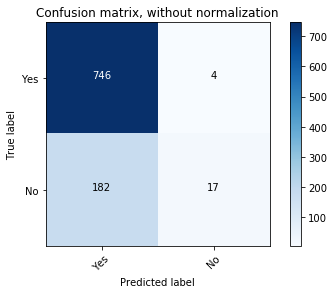

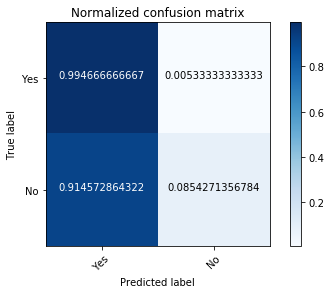

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names=['Yes','No']   
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Prediction for a user review

In [ ]:
X_test=loadDatax('1 or 8-reviews.txt')

counts_train = counter.transform(rev_train)#transform the training data
counts_test = counter.transform(X_test)#transform the testing data

clf = MultinomialNB()
clf.fit(counts_train,labels_train)
pred=clf.predict(counts_test)
print(pred)

We have obtained an accuracy of; 
Parking -> 84.08%
Good for Kids -> 81.96%
Good for Groups -> 81.37%
Outdoor Seating -> 84.25%
Wi-Fi -> 80.71%

Web Scrapping Summarry:

Domain: yelp.com
cuisine: Japanese, Korean, thai
Location: New York
Total Restaurants: 41
Total Reviews: ~= 45000